## Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Load the Dataset

In [2]:
df = pd.read_csv("train.tsv", sep='\t')
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
df.shape

(1482535, 8)

## Exploratory Data Analysis

In [4]:
# Null values in each column
df.isna().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [5]:
# No. of unique values in each column
df.nunique(axis=0)

train_id             1482535
name                 1225273
item_condition_id          5
category_name           1287
brand_name              4809
price                    828
shipping                   2
item_description     1281426
dtype: int64

In [6]:
# Maximum, minimum, mean and median values of price
print(df['price'].max())
print(df['price'].min())
print(df['price'].mean())
print(df['price'].median())

2009.0
0.0
26.737516146330442
17.0


(array([1.472289e+06, 8.335000e+03, 1.169000e+03, 3.990000e+02,
        1.780000e+02, 6.500000e+01, 4.700000e+01, 2.100000e+01,
        1.600000e+01, 1.600000e+01]),
 array([   0. ,  200.9,  401.8,  602.7,  803.6, 1004.5, 1205.4, 1406.3,
        1607.2, 1808.1, 2009. ]),
 <a list of 10 Patch objects>)

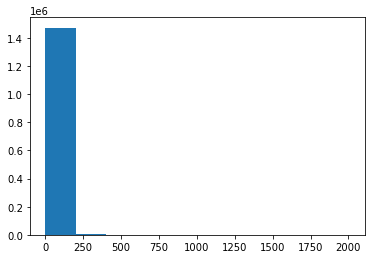

In [7]:
# Histogram for price
plt.hist(df['price'])

(array([8.74000e+02, 1.87030e+04, 1.93836e+05, 6.20246e+05, 4.46867e+05,
        1.53715e+05, 3.83370e+04, 8.41300e+03, 1.34000e+03, 2.04000e+02]),
 array([0.      , 0.760589, 1.521178, 2.281767, 3.042356, 3.802945,
        4.563534, 5.324123, 6.084712, 6.845301, 7.60589 ]),
 <a list of 10 Patch objects>)

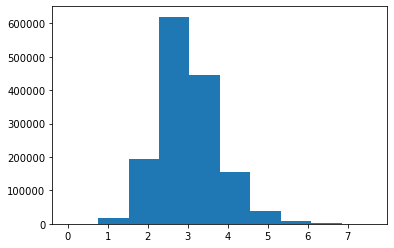

In [8]:
# Histogram of log(price), where log is natural logarithm
plt.hist(np.log1p(df['price'].values))

## Feature Engineering

In [9]:
# Replacing the Null values with 'missing'
df['category_name'].fillna(value='missing', inplace=True)
df['brand_name'].fillna(value='missing', inplace=True)
df['item_description'].fillna(value='No description yet', inplace=True)

df.isna().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [10]:
# Merge the columns 'name', 'category_name', 'brand_name' and 'item_description'
df['name_cat_brand_des'] = (df['name'] + ' ' + df['category_name'] + ' ' + df['brand_name'] + ' ' + df['item_description']).values
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,name_cat_brand_des
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,MLB Cincinnati Reds T Shirt Size XL Men/Tops/T...
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard Electronics/C...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse Women/Tops & Blouses/Blouse Tar...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Leather Horse Statues Home/Home Décor/Home Déc...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,24K GOLD plated rose Women/Jewelry/Necklaces m...


In [11]:
# Split predictors and target
X = df[['name_cat_brand_des', 'item_condition_id', 'shipping']]
y = np.log1p(df['price'].values)

print(X.shape)
print(y.shape)

(1482535, 3)
(1482535,)


In [12]:
X.head()

,name_cat_brand_des,item_condition_id,shipping
0,MLB Cincinnati Reds T Shirt Size XL Men/Tops/T...,3,1
1,Razer BlackWidow Chroma Keyboard Electronics/C...,3,0
2,AVA-VIV Blouse Women/Tops & Blouses/Blouse Tar...,1,1
3,Leather Horse Statues Home/Home Décor/Home Déc...,1,1
4,24K GOLD plated rose Women/Jewelry/Necklaces m...,1,0


In [13]:
y

array([2.39789527, 3.97029191, 2.39789527, ..., 2.56494936, 3.8286414 ,
       3.13549422])

In [14]:
# Convert item_condition_id and shipping to categorical variable
X['item_condition_id'] = X['item_condition_id'].astype('category')
X['shipping'] = X['shipping'].astype('category')

X.head()

<ipython-input-14-3dd4639565a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['item_condition_id'] = X['item_condition_id'].astype('category')
<ipython-input-14-3dd4639565a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['shipping'] = X['shipping'].astype('category')


,name_cat_brand_des,item_condition_id,shipping
0,MLB Cincinnati Reds T Shirt Size XL Men/Tops/T...,3,1
1,Razer BlackWidow Chroma Keyboard Electronics/C...,3,0
2,AVA-VIV Blouse Women/Tops & Blouses/Blouse Tar...,1,1
3,Leather Horse Statues Home/Home Décor/Home Déc...,1,1
4,24K GOLD plated rose Women/Jewelry/Necklaces m...,1,0


In [15]:
X.dtypes

name_cat_brand_des      object
item_condition_id     category
shipping              category
dtype: object

In [16]:
# Removal of punctuations
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

X['name_cat_brand_des'] = X['name_cat_brand_des'].apply(lambda text: remove_punctuation(text))

<ipython-input-16-89a5c0fd2cf7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['name_cat_brand_des'] = X['name_cat_brand_des'].apply(lambda text: remove_punctuation(text))


In [17]:
# Lower casing
X['name_cat_brand_des'] = X['name_cat_brand_des'].str.lower()

<ipython-input-17-9e47ce88aeee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['name_cat_brand_des'] = X['name_cat_brand_des'].str.lower()


In [18]:
# removal of stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

X['name_cat_brand_des'] = X['name_cat_brand_des'].apply(lambda text: remove_stopwords(text))

<ipython-input-18-fb61ca84060f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['name_cat_brand_des'] = X['name_cat_brand_des'].apply(lambda text: remove_stopwords(text))


In [19]:
X.head()

,name_cat_brand_des,item_condition_id,shipping
0,mlb cincinnati reds shirt size xl mentopstshir...,3,1
1,razer blackwidow chroma keyboard electronicsco...,3,0
2,avaviv blouse womentops blousesblouse target a...,1,1
3,leather horse statues homehome décorhome décor...,1,1
4,24k gold plated rose womenjewelrynecklaces mis...,1,0


In [20]:
# Making Pipeline to only implement TF-IDF on name_cat_brand_des column
featurisation = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(stop_words='english'), 'name_cat_brand_des')
])

In [21]:
# Splitting train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1037774, 3)
(444761, 3)
(1037774,)
(444761,)


## Model Building

### Random Forest Regressor

In [23]:
# Random Forest Regression model
rf_model = RandomForestRegressor(max_features='sqrt', oob_score=True, min_samples_leaf=50)

rf_pipeline = Pipeline([('tfidf',featurisation),('rf_model',rf_model)])
rf_pipeline.fit(X_train, y_train)

# Training scores
y_train_rf = rf_pipeline.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_rf)
r2_train_rf = r2_score(y_train, y_train_rf)

print('Training Scores:\n')
print('---------------------------')
print('Mean Squared Error: ', mse_train_rf)
print('R-squared: ', r2_train_rf)

print('\n----------------------------\n')

# Test scores
y_pred_rf = rf_pipeline.predict(X_test)
mse_pred_rf = mean_squared_error(y_test, y_pred_rf)
r2_pred_rf = r2_score(y_test, y_pred_rf)

print('Test Scores:\n')
print('---------------------------')
print('Mean Squared Error: ', mse_pred_rf)
print('R-squared: ', r2_pred_rf)

Training Scores:

---------------------------
Mean Squared Error:  0.39960144684856824
R-squared:  0.2880870600384493

----------------------------

Test Scores:

---------------------------
Mean Squared Error:  0.4015543105323463
R-squared:  0.2846381769355443


### Ridge Regression

In [24]:
# Ridge Regression model
ridge = Ridge()

ridge_pipeline = Pipeline([('tfidf',featurisation),('ridge',ridge)])
ridge_pipeline.fit(X_train, y_train)

# Training scores
y_train_ridge = ridge_pipeline.predict(X_train)
mse_train_ridge = mean_squared_error(y_train, y_train_ridge)
r2_train_ridge = r2_score(y_train, y_train_ridge)

print('Training Scores:\n')
print('---------------------------')
print('Mean Squared Error: ', mse_train_ridge)
print('R-squared: ', r2_train_ridge)

print('\n----------------------------\n')

# Test scores
y_pred_ridge = ridge_pipeline.predict(X_test)
mse_pred_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_pred_ridge = r2_score(y_test, y_pred_ridge)

print('Test Scores:\n')
print('---------------------------')
print('Mean Squared Error: ', mse_pred_ridge)
print('R-squared: ', r2_pred_ridge)

Training Scores:

---------------------------
Mean Squared Error:  0.21982435645811457
R-squared:  0.6083702771462751

----------------------------

Test Scores:

---------------------------
Mean Squared Error:  0.25317948735015566
R-squared:  0.5489652709910523


### XGBoost Regressor

In [25]:
# XGBoost Regression model
xgb = XGBRegressor()

xgb_pipeline = Pipeline([('tfidf',featurisation),('xgb',xgb)])
xgb_pipeline.fit(X_train, y_train)

# Training scores
y_train_xgb = xgb_pipeline.predict(X_train)
mse_train_xgb = mean_squared_error(y_train, y_train_xgb)
r2_train_xgb = r2_score(y_train, y_train_xgb)

print('Training Scores:\n')
print('---------------------------')
print('Mean Squared Error: ', mse_train_xgb)
print('R-squared: ', r2_train_xgb)

print('\n----------------------------\n')

# Test scores
y_pred_xgb = xgb_pipeline.predict(X_test)
mse_pred_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_pred_xgb = r2_score(y_test, y_pred_xgb)

print('Test Scores:\n')
print('---------------------------')
print('Mean Squared Error: ', mse_pred_xgb)
print('R-squared: ', r2_pred_xgb)

Training Scores:

---------------------------
Mean Squared Error:  0.29741744547934584
R-squared:  0.4701337303032992

----------------------------

Test Scores:

---------------------------
Mean Squared Error:  0.3055229826782402
R-squared:  0.4557162701427646


### SGD Regressor

In [26]:
# XGBoost Regression model
sgd = SGDRegressor()

sgd_pipeline = Pipeline([('tfidf',featurisation),('sgd',sgd)])
sgd_pipeline.fit(X_train, y_train)

# Training scores
y_train_sgd = sgd_pipeline.predict(X_train)
mse_train_sgd = mean_squared_error(y_train, y_train_sgd)
r2_train_sgd = r2_score(y_train, y_train_sgd)

print('Training Scores:\n')
print('---------------------------')
print('Mean Squared Error: ', mse_train_sgd)
print('R-squared: ', r2_train_sgd)

print('\n----------------------------\n')

# Test scores
y_pred_sgd = sgd_pipeline.predict(X_test)
mse_pred_sgd = mean_squared_error(y_test, y_pred_sgd)
r2_pred_sgd = r2_score(y_test, y_pred_sgd)

print('Test Scores:\n')
print('---------------------------')
print('Mean Squared Error: ', mse_pred_sgd)
print('R-squared: ', r2_pred_sgd)

Training Scores:

---------------------------
Mean Squared Error:  0.31845400502915366
R-squared:  0.4326558906360788

----------------------------

Test Scores:

---------------------------
Mean Squared Error:  0.3184199623050957
R-squared:  0.43274053157912795


### Lasso Regression

In [ ]:
# Lasso Regression model
lasso = Lasso()

lasso_pipeline = Pipeline([('tfidf',featurisation),('lasso',lasso)])
lasso_pipeline.fit(X_train, y_train)

# Training scores
y_train_lasso = lasso_pipeline.predict(X_train)
mse_train_lasso = mean_squared_error(y_train, y_train_lasso)
r2_train_lasso = r2_score(y_train, y_train_lasso)

print('Training Scores:\n')
print('---------------------------')
print('Mean Squared Error: ', mse_train_lasso)
print('R-squared: ', r2_train_lasso)

print('\n----------------------------\n')

# Test scores
y_pred_lasso = lasso_pipeline.predict(X_test)
mse_pred_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_pred_lasso = r2_score(y_test, y_pred_lasso)

print('Test Scores:\n')
print('---------------------------')
print('Mean Squared Error: ', mse_pred_lasso)
print('R-squared: ', r2_pred_lasso)

Training Scores:

---------------------------
Mean Squared Error:  0.5613066211019427
R-squared:  0.0

----------------------------

